In [1]:
#un canale

In [2]:
from LibraryENGcopia import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3

In [3]:
#data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
data = h5py.File(complete_string3,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(5875000, 60)


In [4]:
inizio=0
#len_data=810000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :17]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'46']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(5875000,) (5875000,)


In [5]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
r_prova=prova.reshape(-1, 1)
scaler = StandardScaler()
s_prova = scaler.fit_transform(r_prova)
prova=s_prova
s_prova.shape

(5875000, 1)

# Spike detection

In [6]:
pos, neg=find_all_spikes(prova)

100%|████████████████████████████▉| 5874693/5874700 [00:16<00:00, 363199.34it/s]

detected spikes: 63671 firing rate:  108.37617021276596


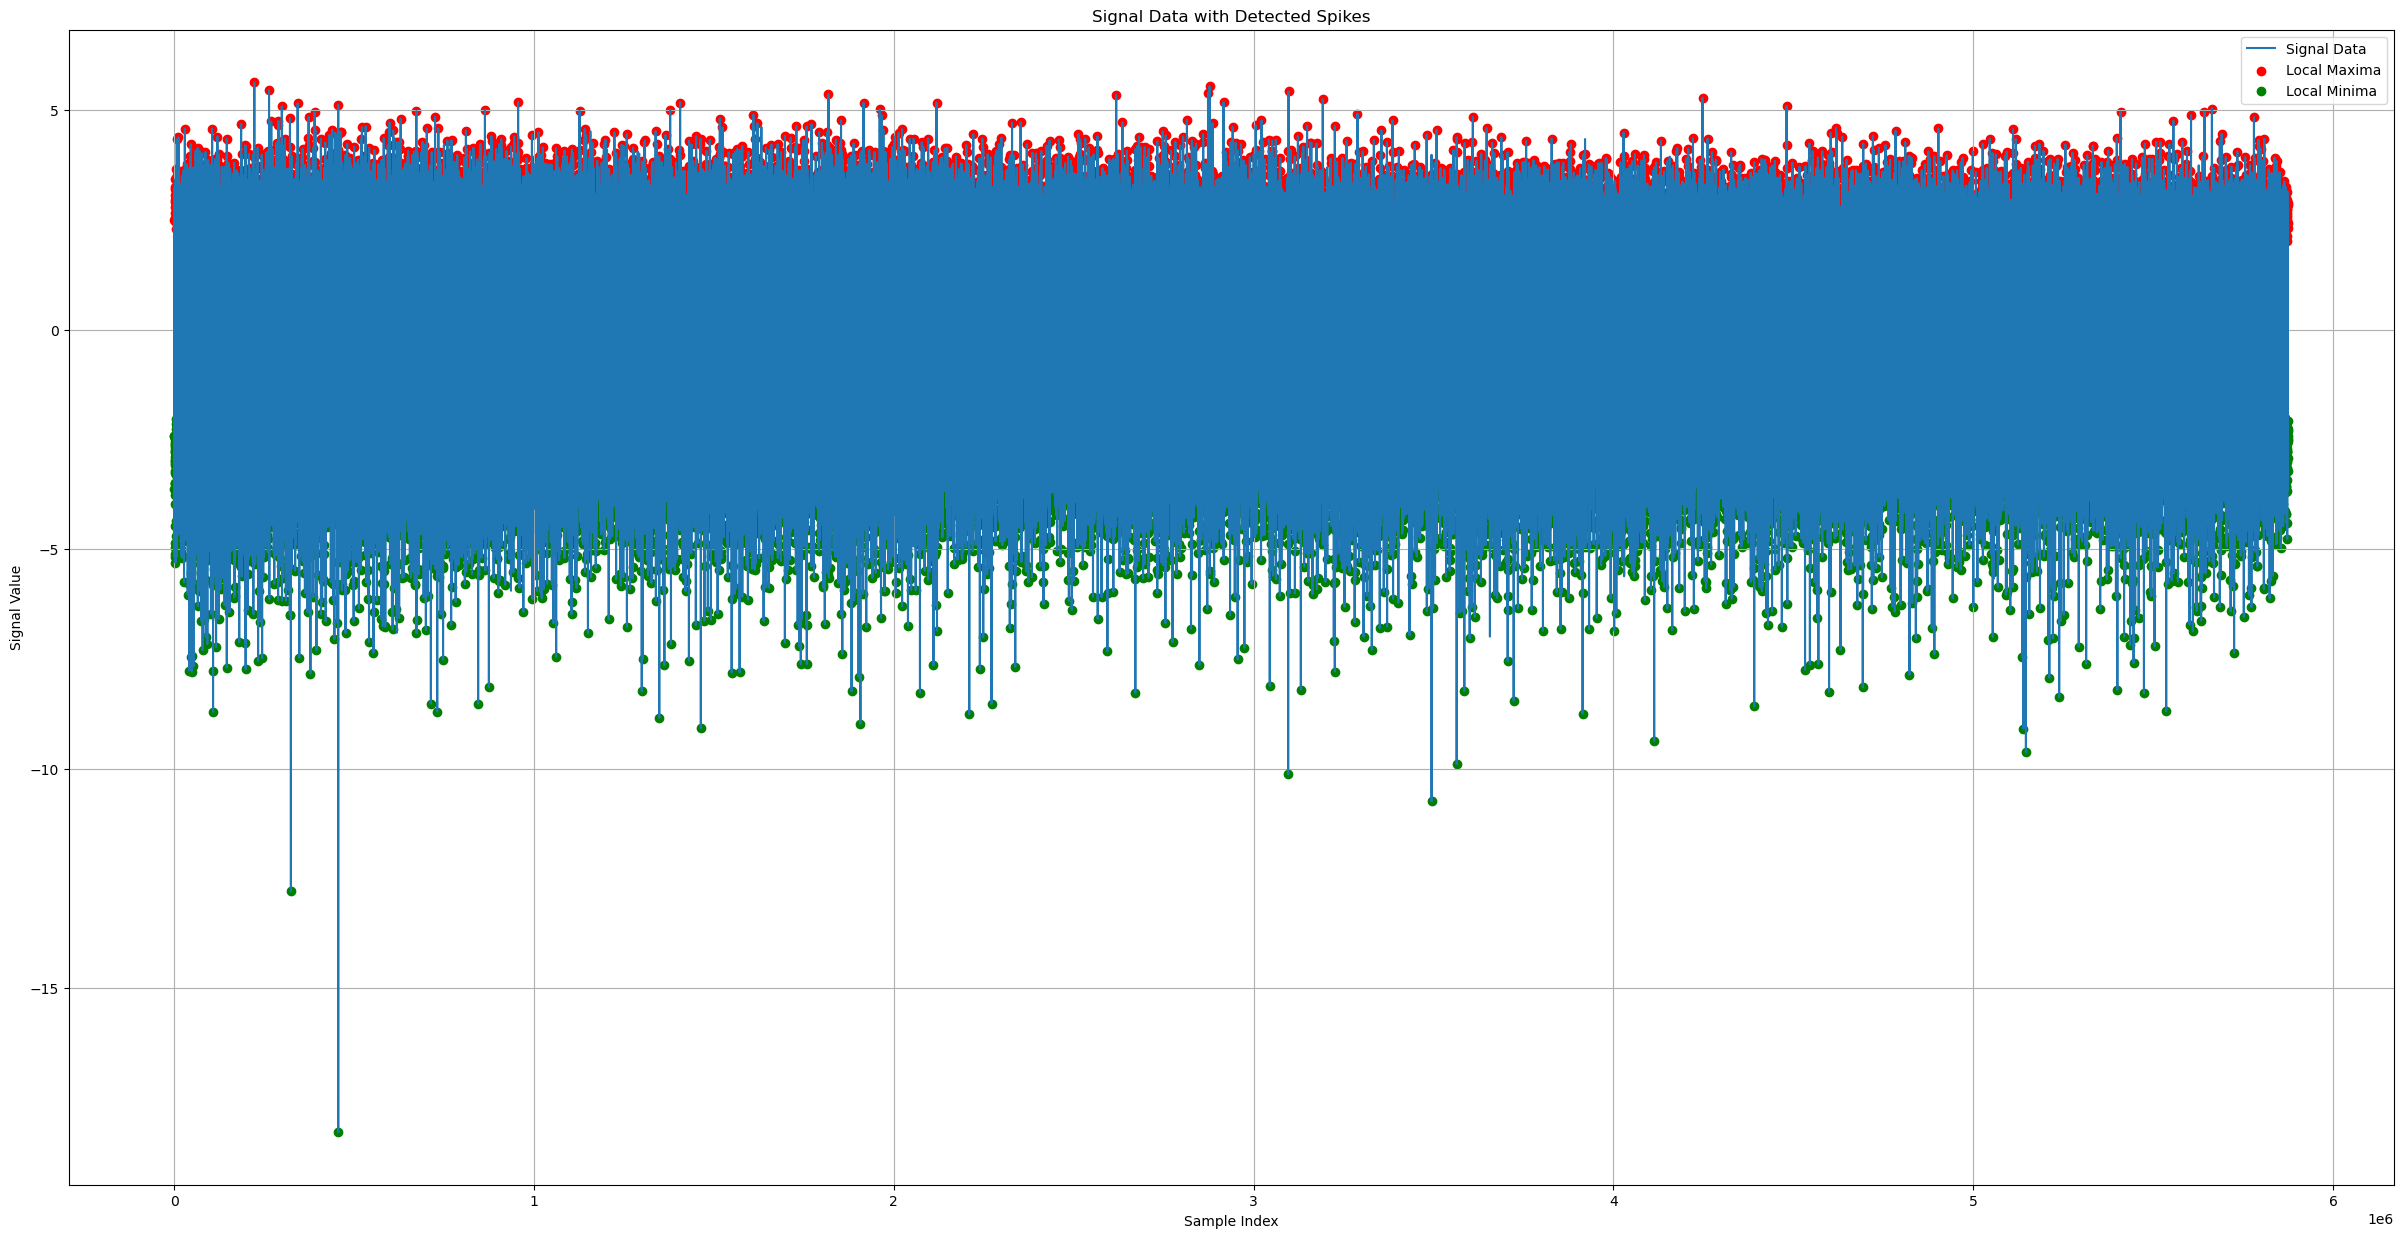

In [7]:
plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

In [ ]:
minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

In [ ]:
minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

In [ ]:
minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
# segnale KA stimulation: firing rate=8 (spikes 5054)

In [ ]:
plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [9]:
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova)
savedp = copy.deepcopy(pos_cut)
savedn = copy.deepcopy(neg_cut)

0 21828 21828 0 6602 6602


In [10]:
pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

(21828, 30)
(6602, 30)


In [ ]:
x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
plt.plot(savedn[x])
plt.plot(neg_cut[x])
plt.show()

In [13]:
import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

Explained Variance DataFrame:


,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Explained Variance,0.258278,0.191529,0.119656,0.106423,0.069737,0.057089,0.038862,0.031148,0.024076,0.020753,...,0.000141,0.000023,0.000003,3.165020e-07,2.539276e-08,1.818514e-09,9.675414e-11,4.078808e-12,1.059620e-13,1.392831e-15


In [14]:
cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


Cumulative Explained Variance DataFrame:


,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Cumulative Explained Variance,0.258278,0.449807,0.569463,0.675885,0.745622,0.802711,0.841573,0.872721,0.896797,0.91755,...,0.999974,0.999997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Clustering

Total spikes:  21828
transformed
For 3 clusters, the silhouette score is: 0.21246368846978936


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


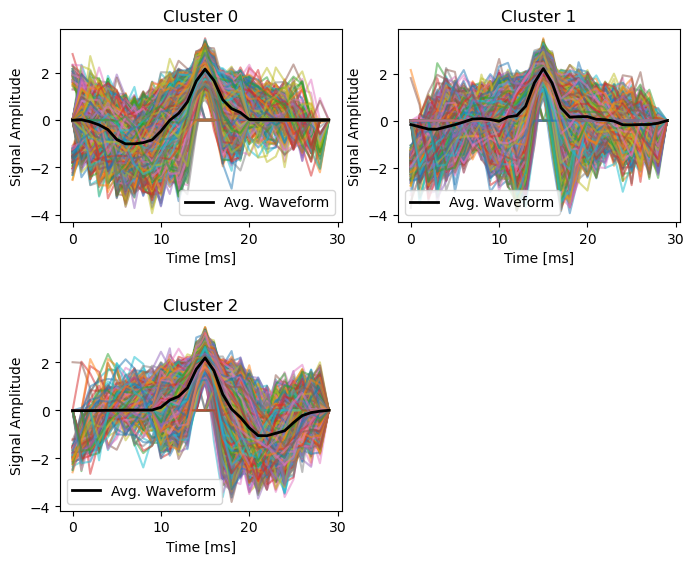

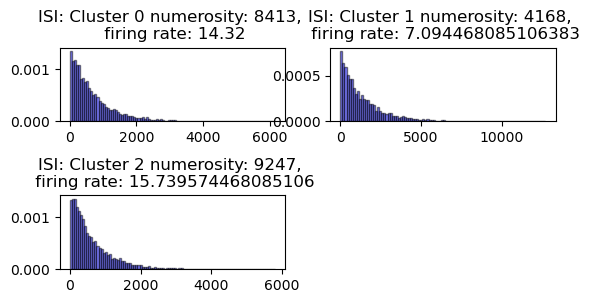

In [11]:
final_data_pos= clus(pos_cut,'PCA','fuzzy',n_pos,3,len_data)

Total spikes:  6602
transformed
For 2 clusters, the silhouette score is: 0.20646861040648967


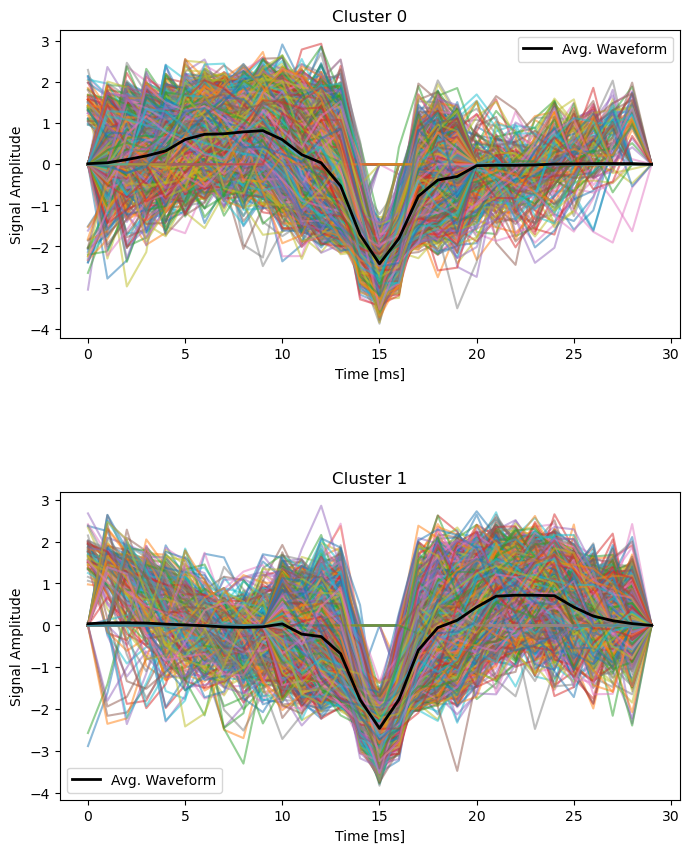

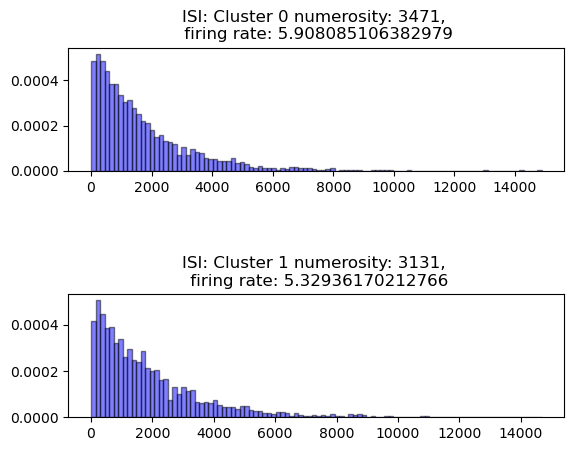

In [12]:
final_data_neg= clus(neg_cut,'PCA','fuzzy',n_neg,2,len_data)

In [13]:
neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

[array([    196,     830,     947, ..., 5873475, 5873964, 5874474]),
 array([    951,    1329,    1815, ..., 5872909, 5873337, 5874183]),
 array([   2630,    5447,    6310, ..., 5873557, 5873649, 5874558]),
 array([    840,    1092,    1825, ..., 5871955, 5872336, 5873586]),
 array([    876,    4213,    6658, ..., 5867216, 5872554, 5873099])]

In [54]:
data_healthy=neurons[2]
ISI_healthy = np.diff(data_healthy)/10000

## Point Process

In [55]:
ISI_data=ISI_healthy
with pm.Model() as model:
    ##### WALD DISTRIBUTION (INVERSE GAUSSIAN)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald.dist(mu=mu1,lam=lam1)


    mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
    sigma2 = pm.Uniform('sigma2',lower=0.0001,upper=0.5)
    obs2 = pm.TruncatedNormal.dist(mu=mu2, sigma=sigma2, lower=0.0)

    mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
    sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
    obs3 = pm.TruncatedNormal.dist(mu=mu3, sigma=sigma3, lower=0.0)


    w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
    #w = pm.Dirichlet('w', a=np.array([1., .4]))

    like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)
    #like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2], observed=ISI_data)
    map_estimate = pm.find_MAP(model=model)
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,chains=1,tune=1000,cores=4)


Sequential sampling (1 chains in 1 job)
NUTS: [mu1, lam1, mu2, sigma2, mu3, sigma3, w]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 202 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling: [like]


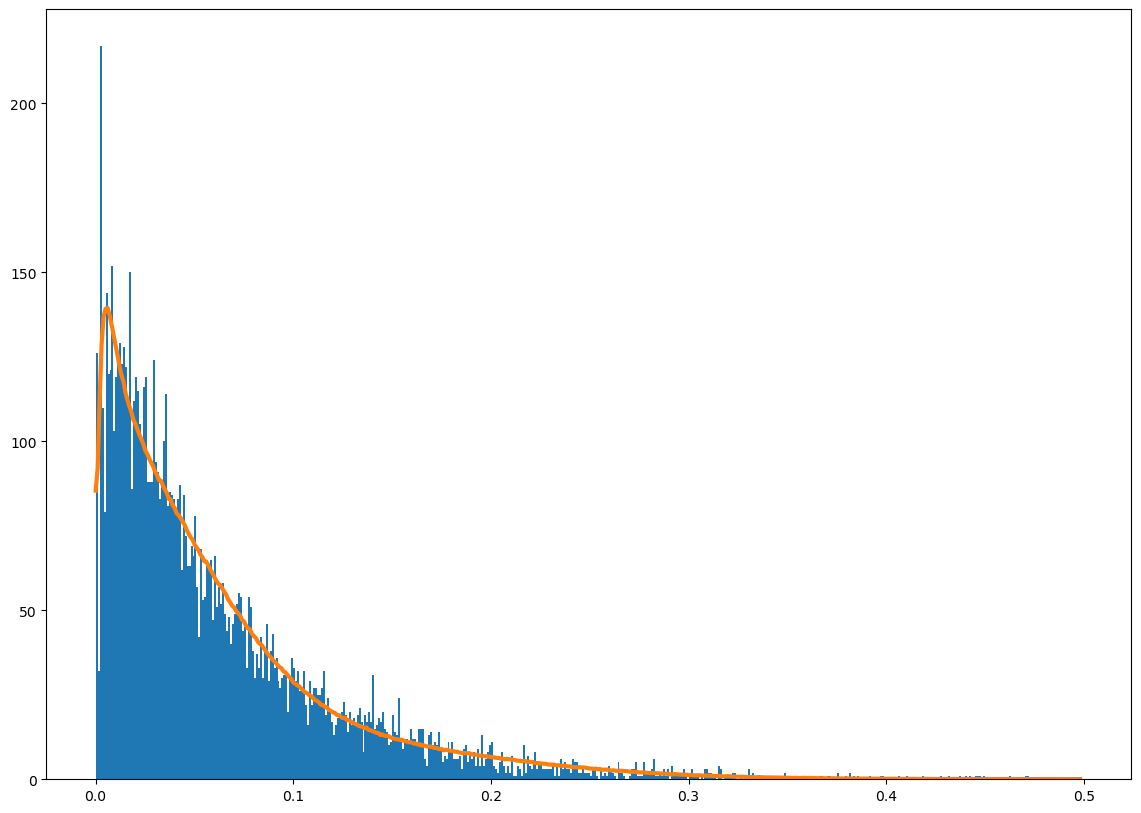

In [56]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [57]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

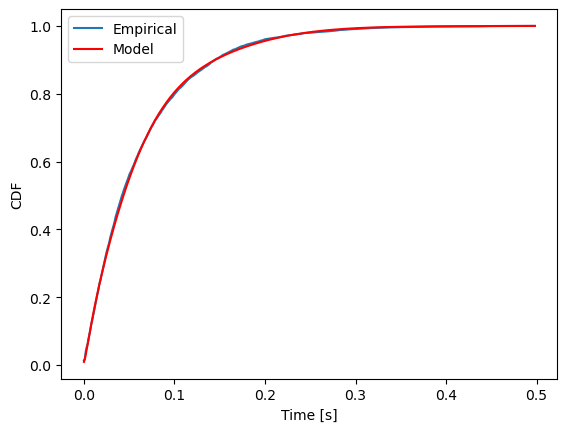

In [58]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

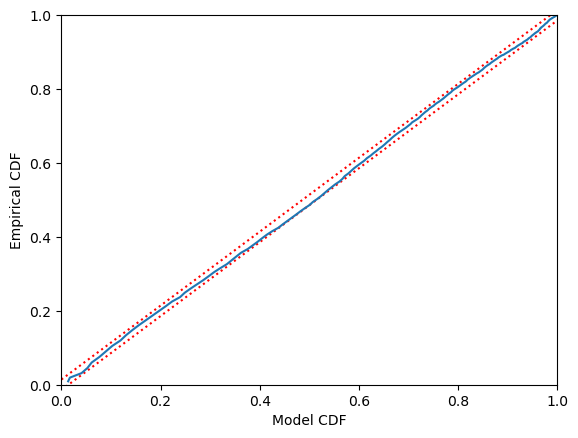

In [59]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [60]:
map_estimate = pm.find_MAP(model=model)
del map_estimate['w_simplex__']
del map_estimate['mu1_interval__']
del map_estimate['lam1_interval__']
del map_estimate['mu2_interval__']
del map_estimate['sigma2_interval__']
del map_estimate['mu3_interval__']
del map_estimate['sigma3_interval__']

map_estimate['w1'] = map_estimate['w'][0]
map_estimate['w2'] = map_estimate['w'][1]
map_estimate['w3'] = map_estimate['w'][2]

del map_estimate['w']


map_estimate

{'mu1': array(0.0585939),
 'lam1': array(0.03423544),
 'mu2': array(5.7932706e-111),
 'sigma2': array(0.08184228),
 'mu3': array(0.1),
 'sigma3': array(0.00010089),
 'w1': 0.34212080707303694,
 'w2': 0.6578791929269631,
 'w3': 1.9524243774789846e-119}